### Задание 1
Cформировать прогноз показателя "target" для тестовой выборки  
Целевые метрики:
* ошибка = sum(abs(target-forecast))/sum(target) --> 0
* баланс = sum(target-forecast)/sum(target) --> 0  

Структура возвращаемого датасета:
* warehouse
* article
* year_week
* forecast

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# Известные данные
df = pd.read_csv('train.csv')

In [3]:
df.head(10)

,warehouse,article,year_week,price,target
0,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",202038,49.6,0.0
1,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",202104,49.6,0.0
2,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",201947,49.6,0.0
3,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",202040,49.6,1.0
4,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",202048,43.3,0.0
5,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",201945,38.5,0.0
6,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",201901,49.6,0.0
7,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",202010,49.6,5.0
8,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",201948,49.6,0.0
9,сергиев посад-6 городок №1,"йогурты вязкие даниссимо 6,9% 105г №7",201921,49.6,3.0


# EDA

## Target

У нас низкая детализация, поэтому строк в данных много

In [4]:
df.shape

(1052635, 5)

 Что можем заметить сразу - так это то, что у нас в данном датасете ультранизкий таргет

In [5]:
# собираемся учиться на ультранизкий таргет
df['target'].describe()

count    1.035144e+06
mean     2.173175e+00
std      6.961066e+00
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      8.930000e+02
Name: target, dtype: float64

Есть пропуски в таргете - 3 пути решения - заполнить 0, средним (медианой) или убрать из датасета

In [6]:
df.isna().sum()

warehouse        0
article          0
year_week        0
price            0
target       17491
dtype: int64

Посмотрим на строки, в которых у нас пропуски

In [7]:
len(df['article'].unique())

842

In [8]:
# Пропуски есть практически для всех товаров
len(df['article'].unique()) - len(df[df['target'].isna()]['article'].unique())

25

In [9]:
len(df['warehouse'].unique())

7301

In [10]:
# Практически для всех ТО
len(df[df['target'].isna()]['warehouse'].unique())

6946

In [11]:
# нет какого-то четкого распределения по дате
df[df['target'].isna()]['year_week'].unique()

array([201845, 202035, 202031, 201851, 201918, 202012, 201911, 202052,
       202103, 201948, 201913, 202038, 201922, 201930, 202024, 202034,
       202027, 201901, 202019, 202041, 201953, 202013, 202045, 202014,
       202039, 202047, 202044, 202111, 202030, 202004, 201849, 201937,
       201846, 201943, 202049, 202107, 202032, 201933, 202037, 201942,
       201921, 201935, 201852, 201945, 202106, 201928, 201924, 202003,
       201927, 202025, 201914, 201919, 202108, 201932, 201920, 202002,
       202029, 202007, 201850, 202009, 201910, 202109, 202010, 202051,
       202104, 202026, 202036, 201917, 202011, 202008, 201940, 201925,
       201952, 201929, 201931, 201947, 201926, 202022, 201908, 201938,
       201946, 202046, 202110, 202040, 202001, 202048, 201950, 202043,
       201902, 202017, 201939, 202112, 202033, 202005, 201904, 201941,
       201912, 201949, 201853, 201951, 202020, 202018, 202028, 202021,
       201848, 201905, 201916, 202015, 202050, 202105, 202006, 201907,
      

In [12]:
df[df['target'].isna()]['article'].value_counts()

горячий шоколад maссoffee 20г №1               126
йогурты вязкие активиа 3% 110г №2              107
корма для кошек whiskas 75г №2                 101
корма для кошек kitekat 85г №4                  99
корма для кошек felix 75г №19                   99
                                              ... 
кефир дабрович 2,5% 0,9л №1                      1
кефир тульский 3,2% 900г №1                      1
йогурты вязкие молочный родник 2,5% 300г №2      1
пиво велкопоповицкий козел 0,45л №2              1
кефир ирбитский мз 1% 0,5л №1                    1
Name: article, Length: 817, dtype: int64

In [13]:
# пропуски лучше удалить - не несут для нас какой-то важной информации
df = df.dropna(subset=['target'])

# Article

В датасете присутствуют товарные группы - хорошо, можем описать товар и посмотреть на спрос в рамках товарной группы

In [14]:
df['article'].unique()[:20]

array(['йогурты вязкие даниссимо 6,9% 105г №7',
       'корма для кошек felix 48г №1', 'джин вайт лейс 40% №1',
       'корма для кошек sheba 75г №3', 'корма для кошек felix 75г №13',
       'средства для борьбы с летающими насекомыми раптор  №4',
       'соковая продукция мой 0,95л №1', 'напитки evervess 1л №6',
       'соковая продукция магнит 1л №3', 'соковая продукция добрый 1л №5',
       'кефир княгинино 2,5% 430г №2', 'корма для кошек whiskas 75г №15',
       'йогурты вязкие bio max 2,9% 106г №1', 'напитки riсh 1л №1',
       'бренди крымский статус 40% 0,1л №1',
       'йогурты вязкие фругурт 2,5% 0,25кг №1', 'пиво amstel 0,33л №1',
       'джин j logans 38% 0,7л №1',
       'кофе растворимый jaсobs monarсh 95г №4',
       'йогурты вязкие вятушка 4% 180г №1'], dtype=object)

In [18]:
def return_group(name: str, count_ngrams: int = 3):
    ngrams = [' '.join(name.split()[:i]) for i in range(1, count_ngrams + 1)]
    max_value = 0
    selected_group = None
    
    for gram in ngrams:
        count_values = len(df[df['article'].str.contains(gram)]['article'])
                           
        if count_values >= max_value:
            selected_group = gram
            max_value = count_values
                           
    return selected_group

In [19]:
groups = [return_group(article) for article in tqdm(df['article'].unique())]

  0%|          | 0/842 [00:00<?, ?it/s]

/var/folders/9g/_5ffyp2n731d2wgcprc6zswh0000gn/T/ipykernel_48391/3004775273.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count_values = len(df[df['article'].str.contains(gram)]['article'])


In [20]:
set(groups)

{'бренди',
 'горячий шоколад',
 'джин',
 'йогурты вязкие',
 'кефир',
 'корма для',
 'кофе растворимый',
 'напитки',
 'пиво',
 'соковая продукция',
 'средства',
 'чистящие средства'}

In [21]:
list_categories = ['бренди', 'горячий шоколад', 'джин', 'йогурты вязкие', 'кефир', 'корма для собак',
                   'кофе растворимый', 'напитки', 'пиво', 'соковая продукция', 'корма для кошек', 
                   'средства для борьбы с летающими насекомыми', 'чистящие средства']

In [22]:
df['category'] = None

for category in list_categories:
    idx = df['article'].str.contains(category)
    
    df.loc[idx, 'category'] = category

Детализация до категории имеет место быть

<AxesSubplot: >

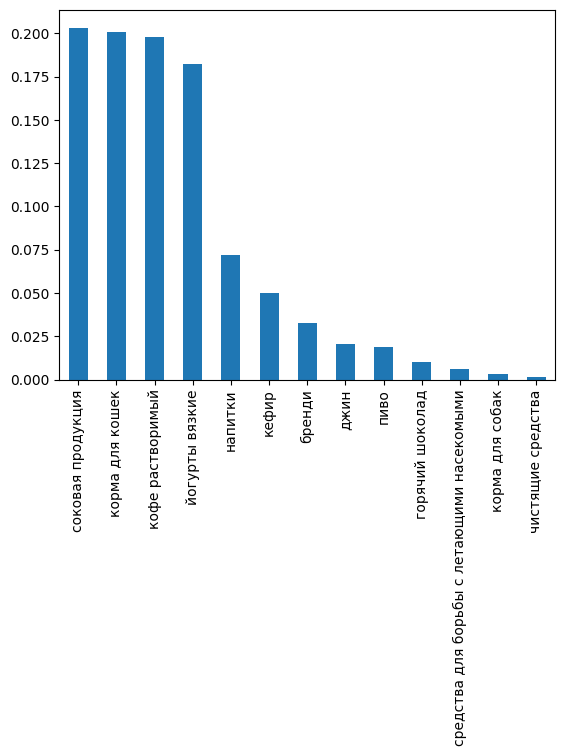

In [23]:
df['category'].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot: xlabel='category'>

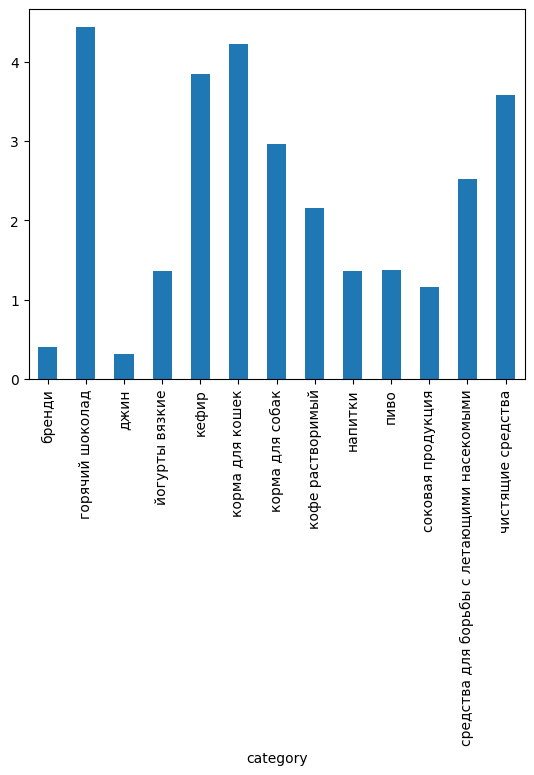

In [24]:
df.groupby('category')['target'].mean().plot(kind='bar')

<AxesSubplot: xlabel='category'>

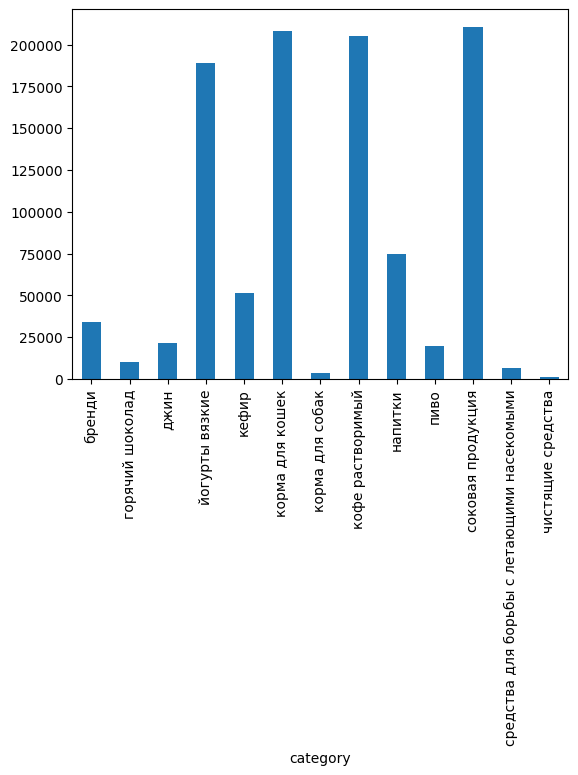

In [26]:
df.groupby('category')['target'].count().plot(kind='bar')

# Warehouse

In [27]:
df['warehouse'].unique()

array(['сергиев посад-6 городок №1', 'бор №1', 'стерлитамак №21', ...,
       'екатеринбург №71', 'курган №11', 'ирбит №2'], dtype=object)

In [28]:
cities_list = list(set([' '.join(whs_name.split()[:-1]) for whs_name in df['warehouse'].unique()]))

In [30]:
df['city'] = df['warehouse'].apply(lambda x: ' '.join(x.split()[:-1]))

<AxesSubplot: >

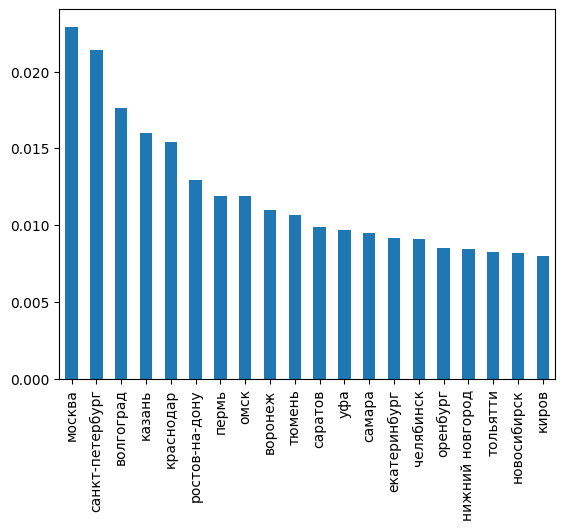

In [33]:
df['city'].value_counts(normalize=True)[:20].plot(kind='bar')

# Year_week

In [34]:
df['year_week'].min(), df['year_week'].max() 

(201845, 202112)

In [41]:
top_cities = df['city'].value_counts(normalize=True)[:20].index

In [ ]:
# строим модель до города

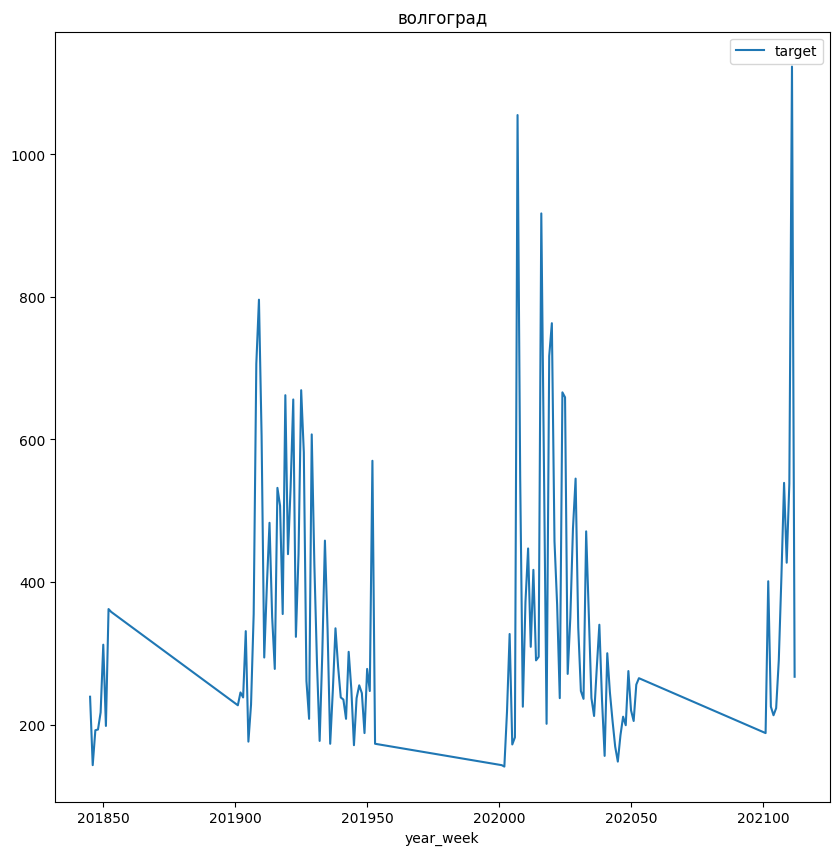

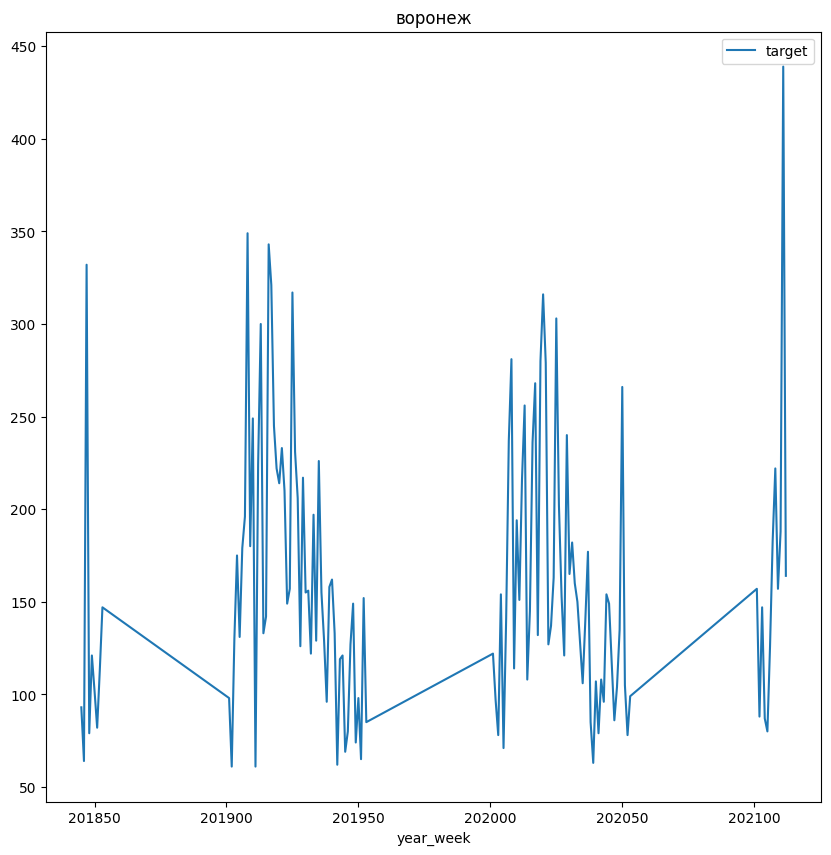

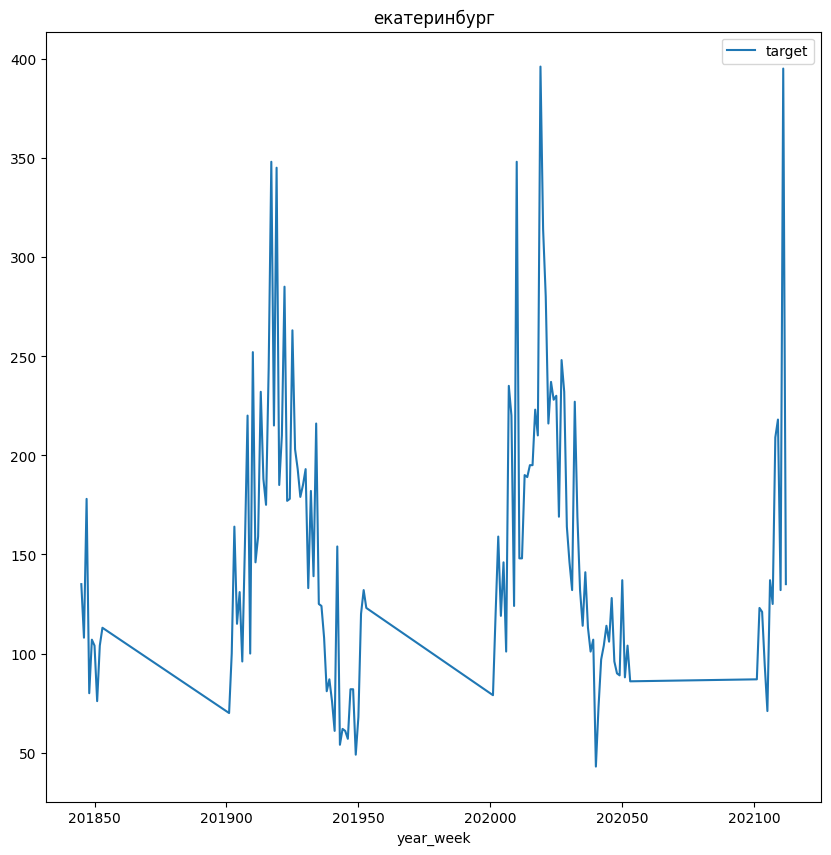

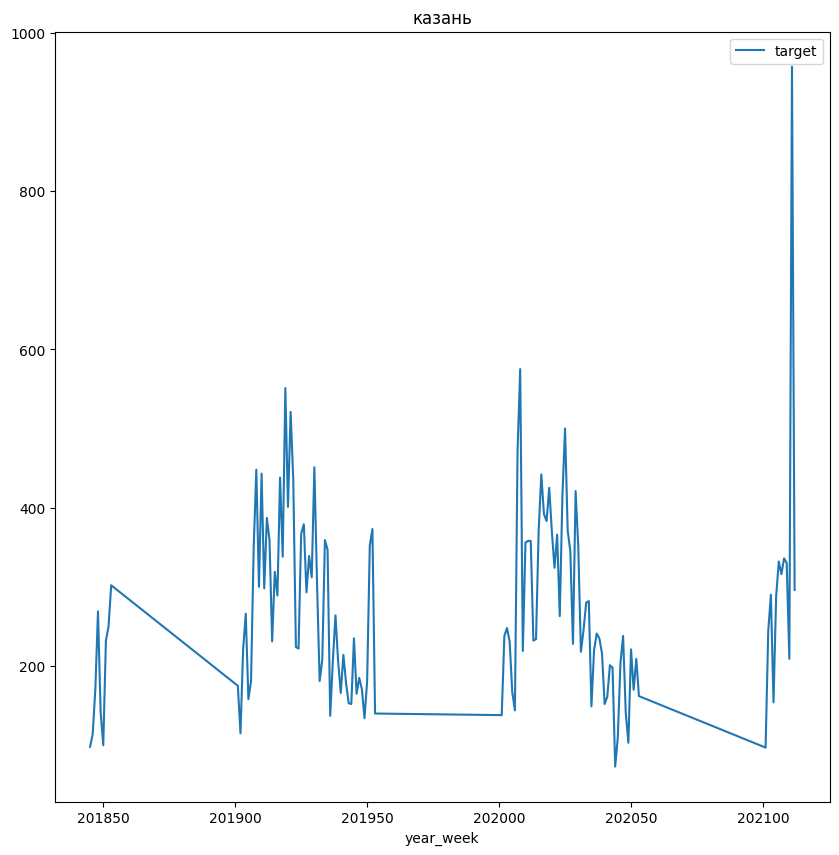

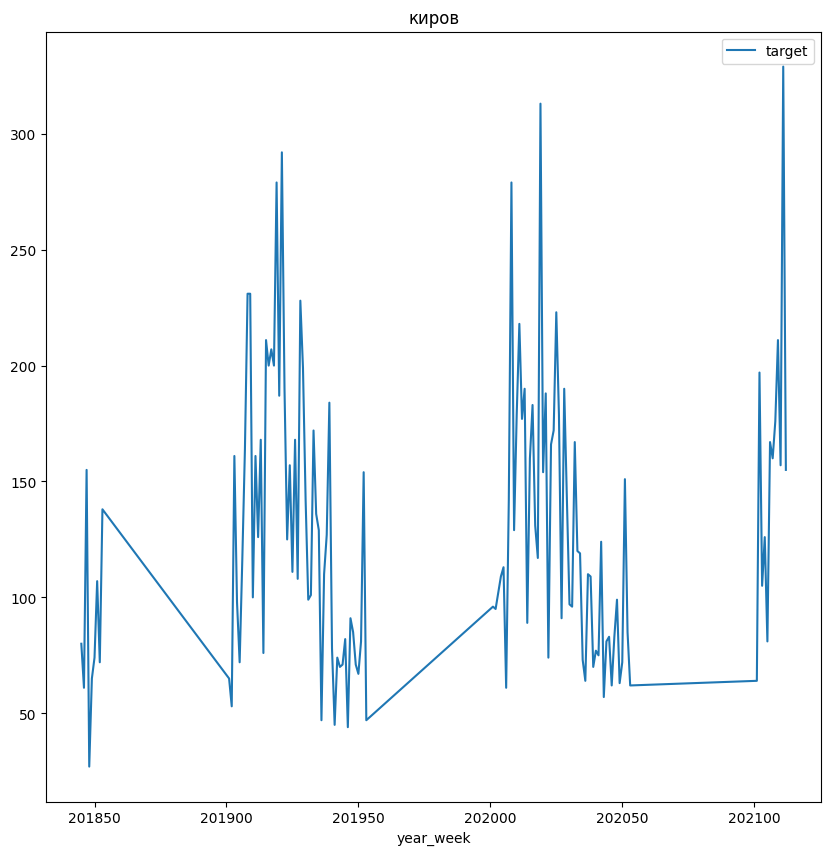

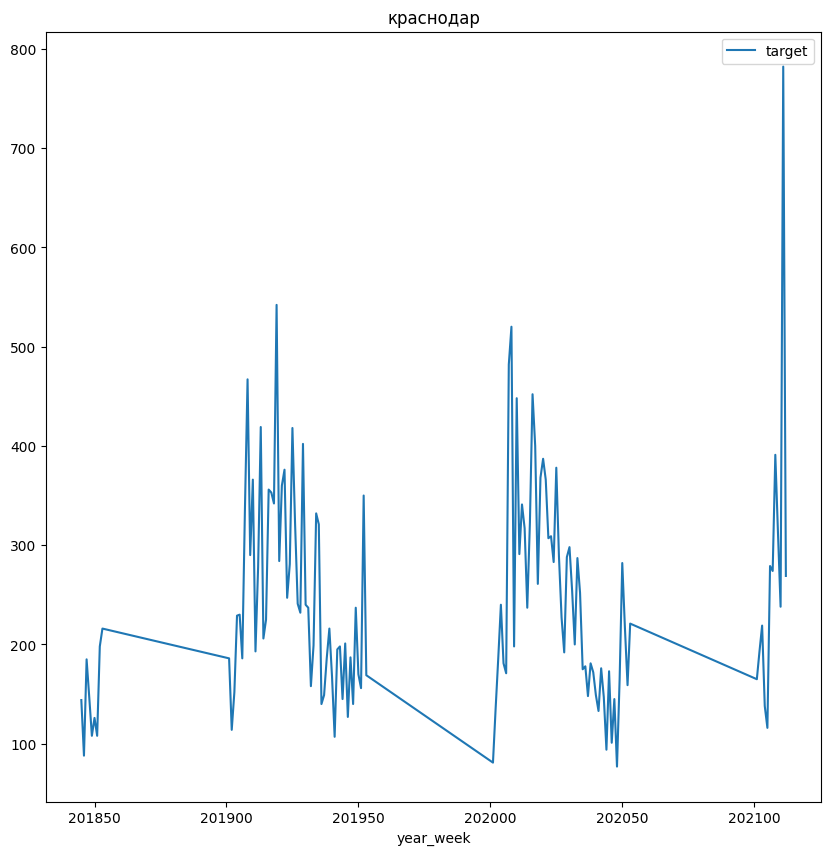

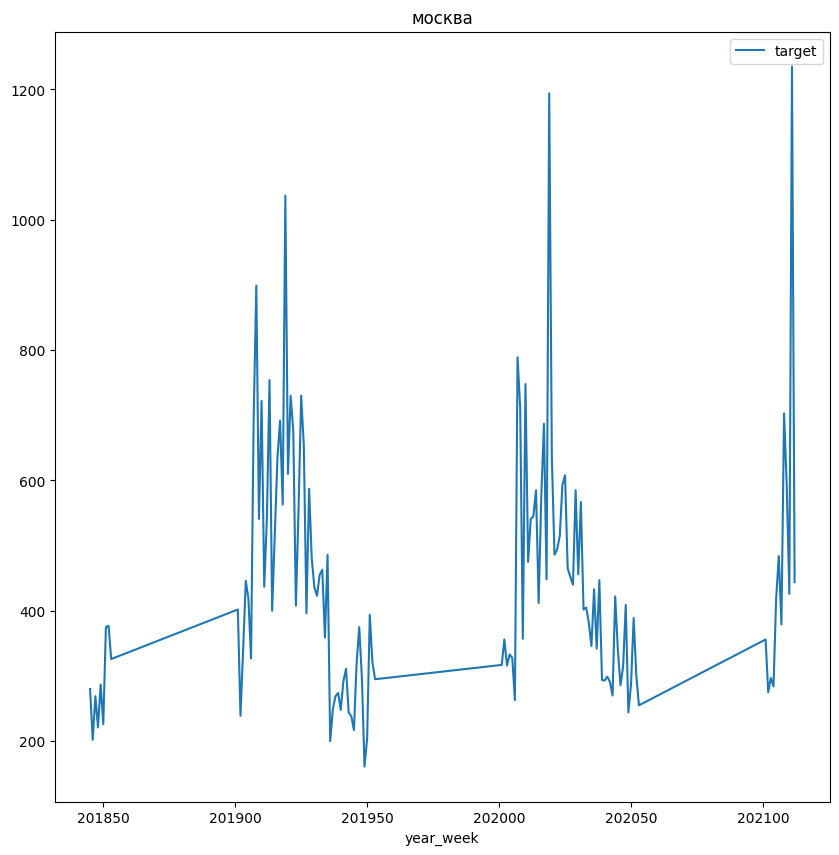

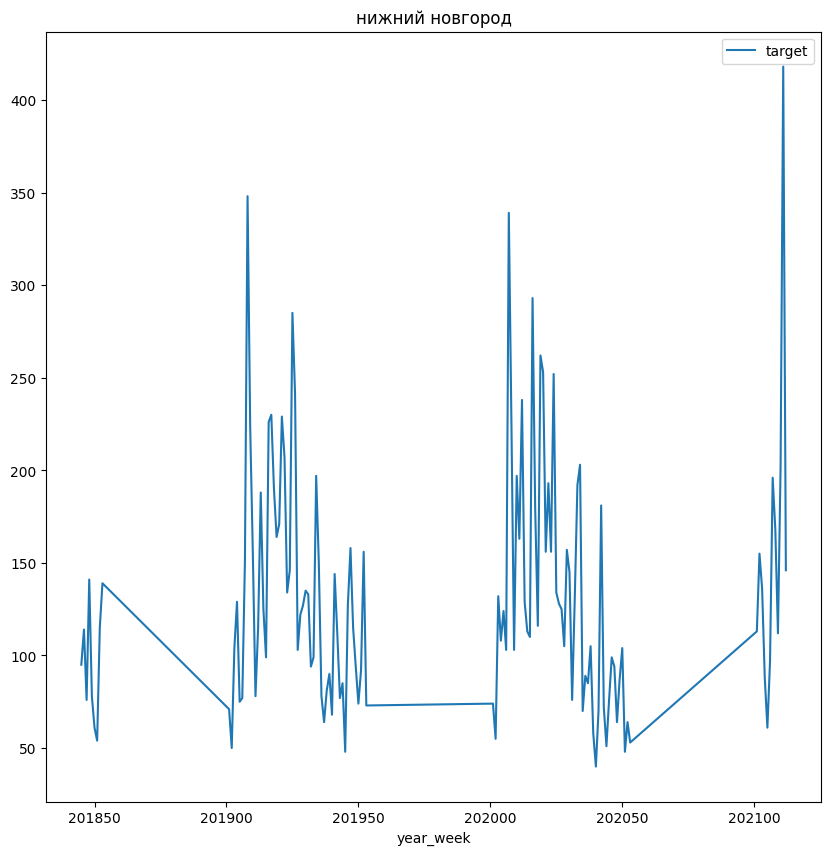

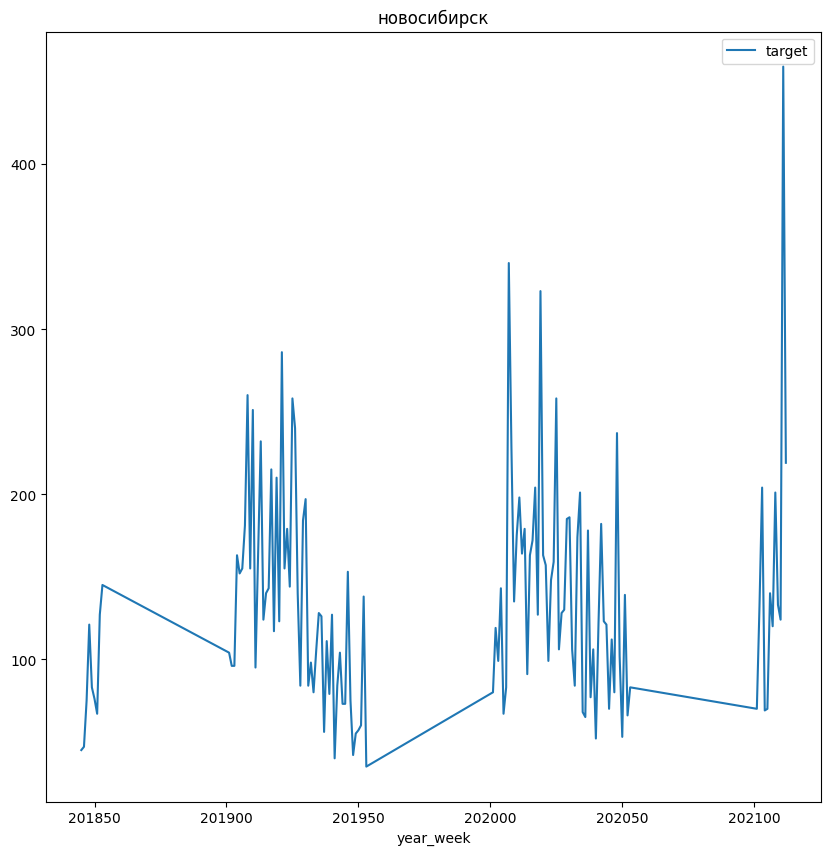

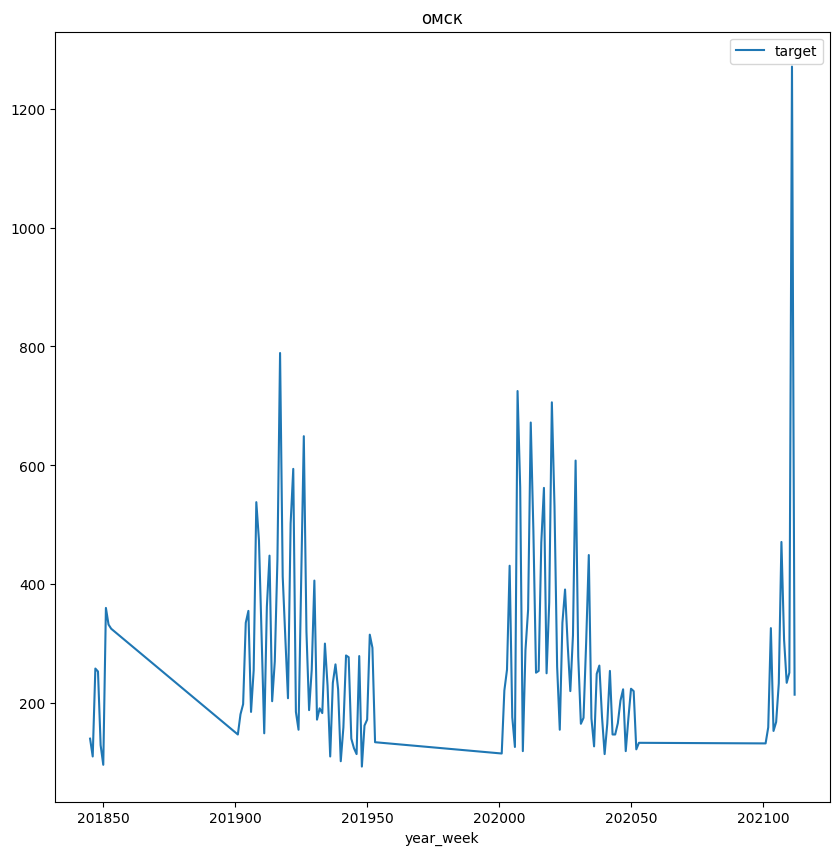

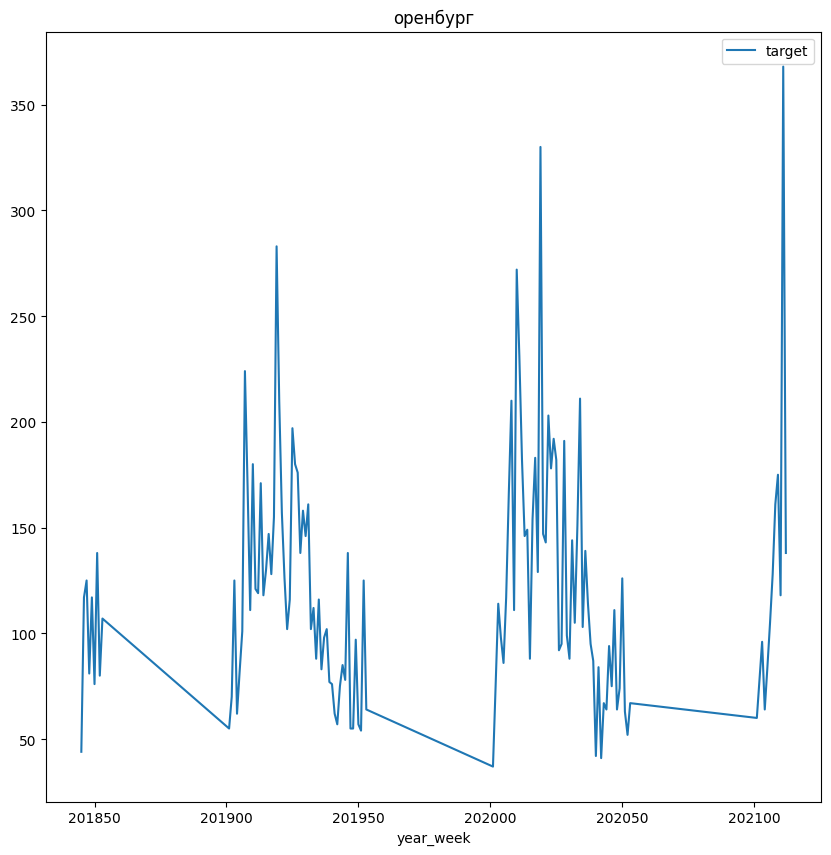

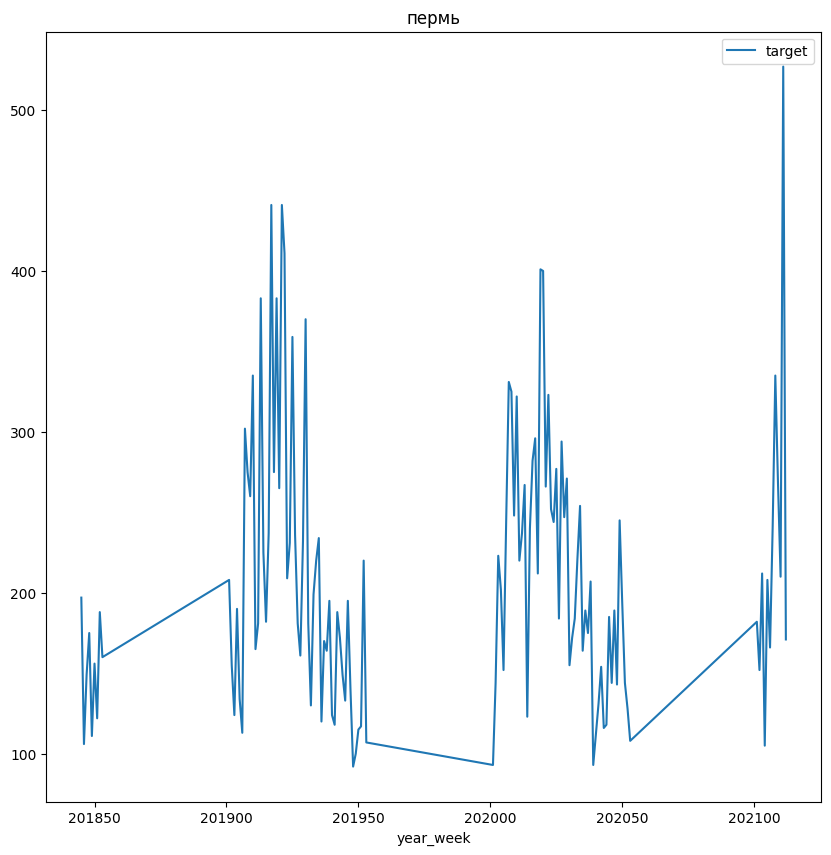

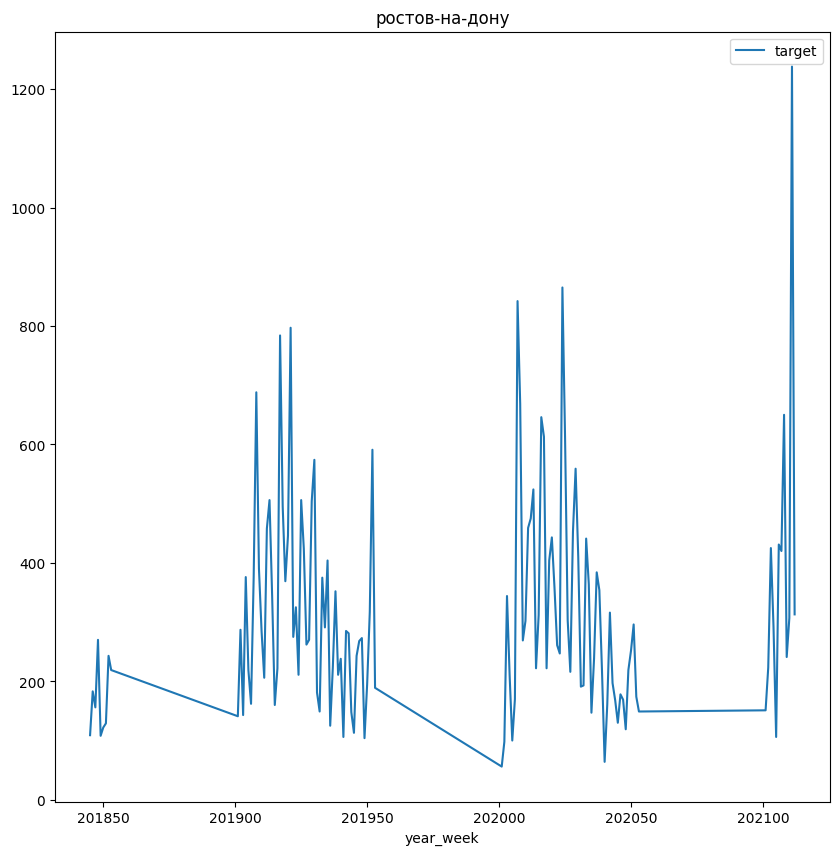

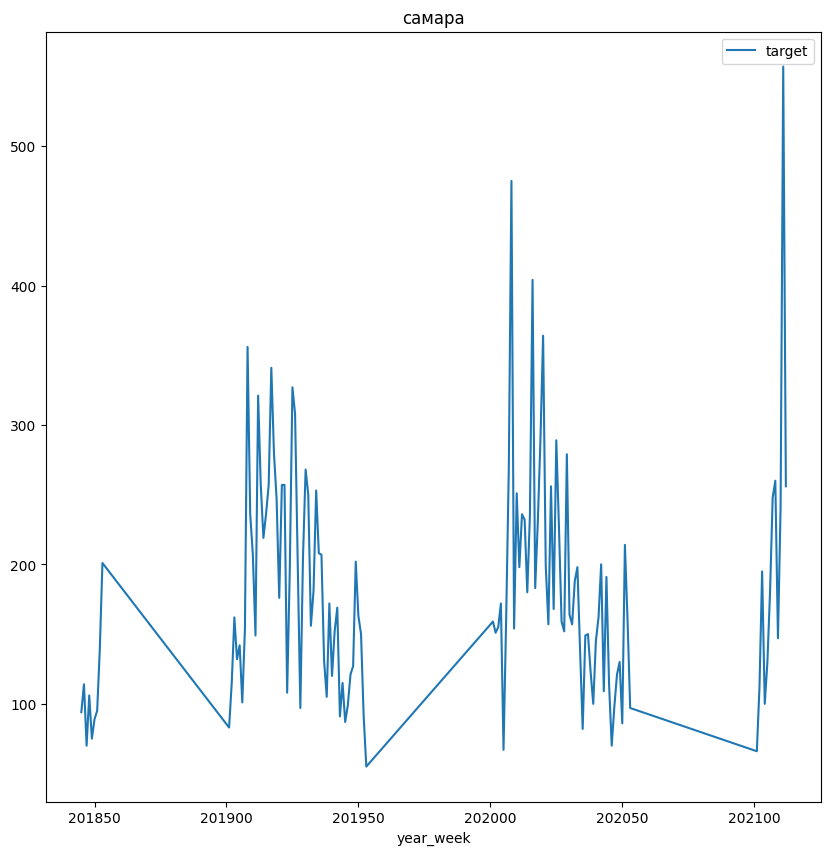

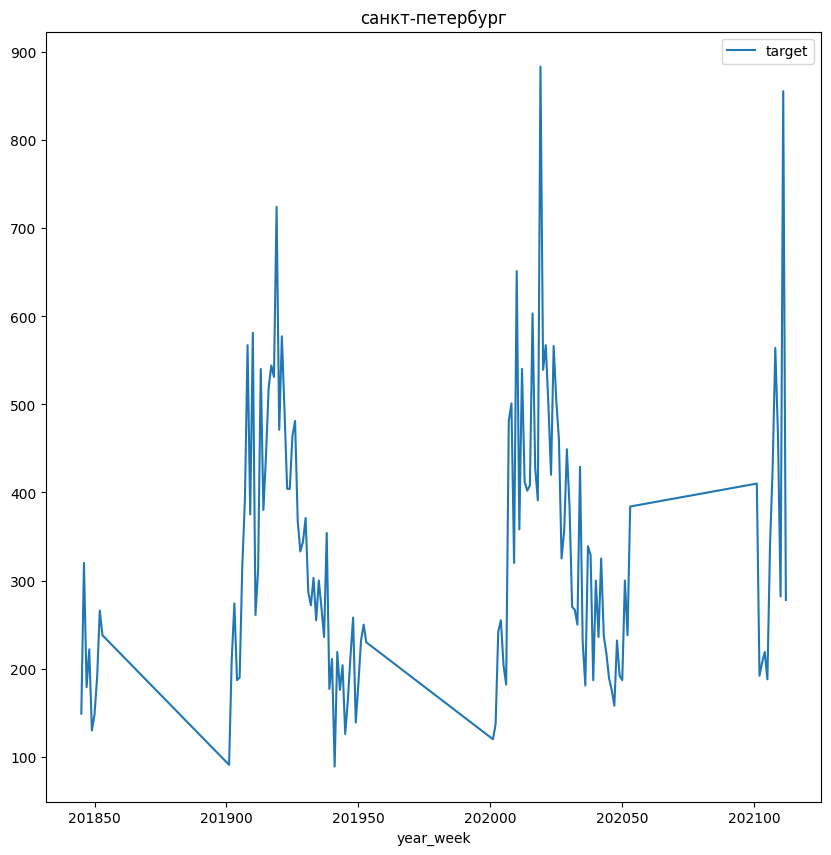

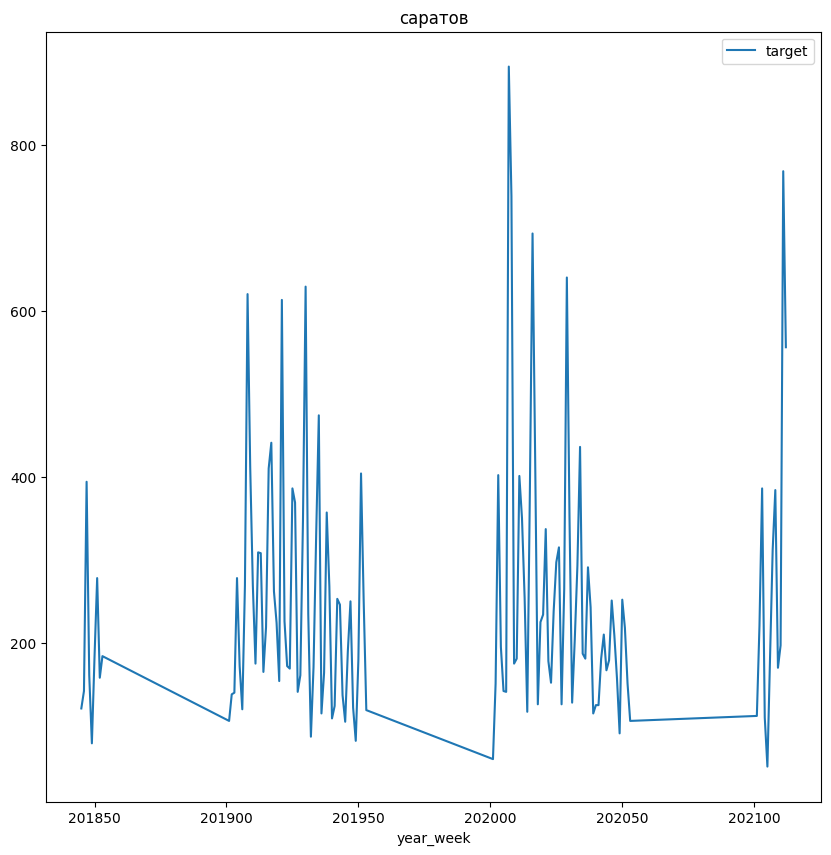

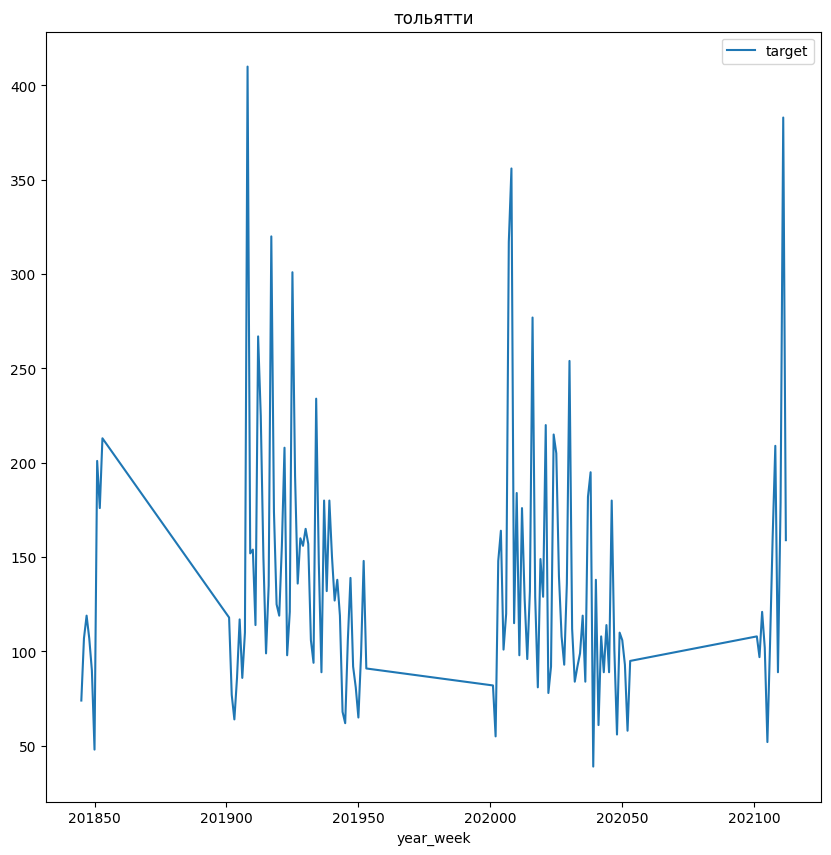

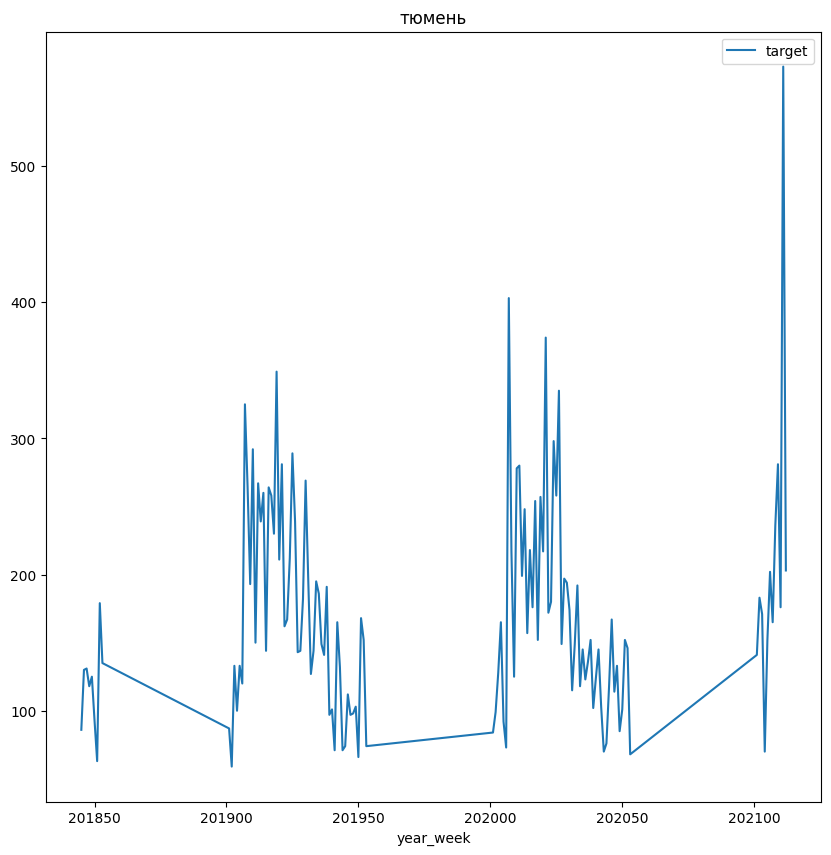

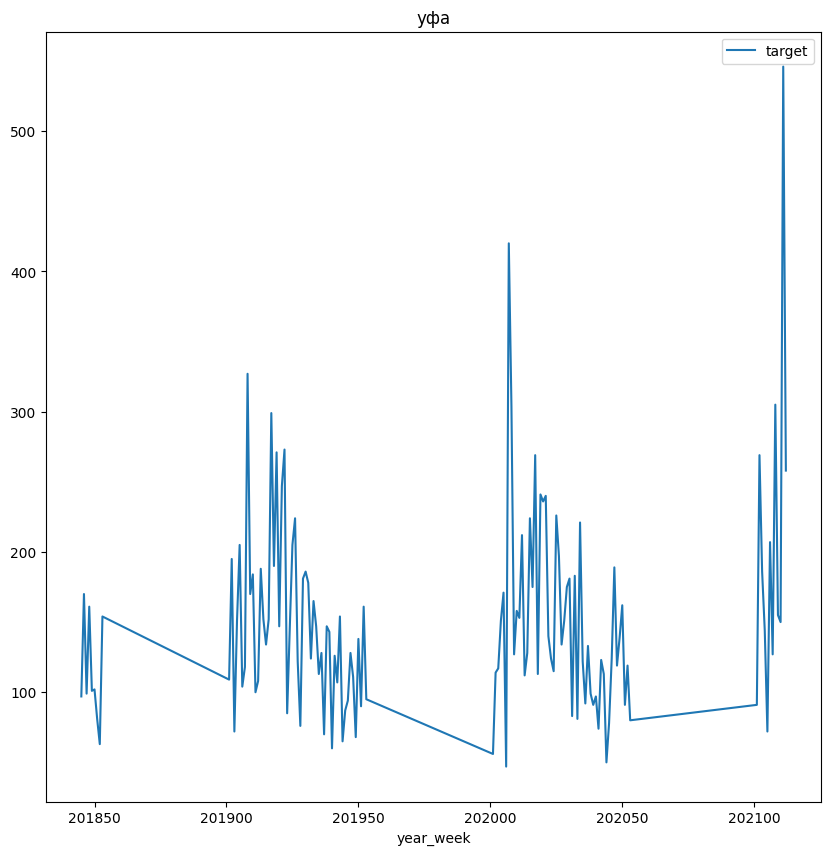

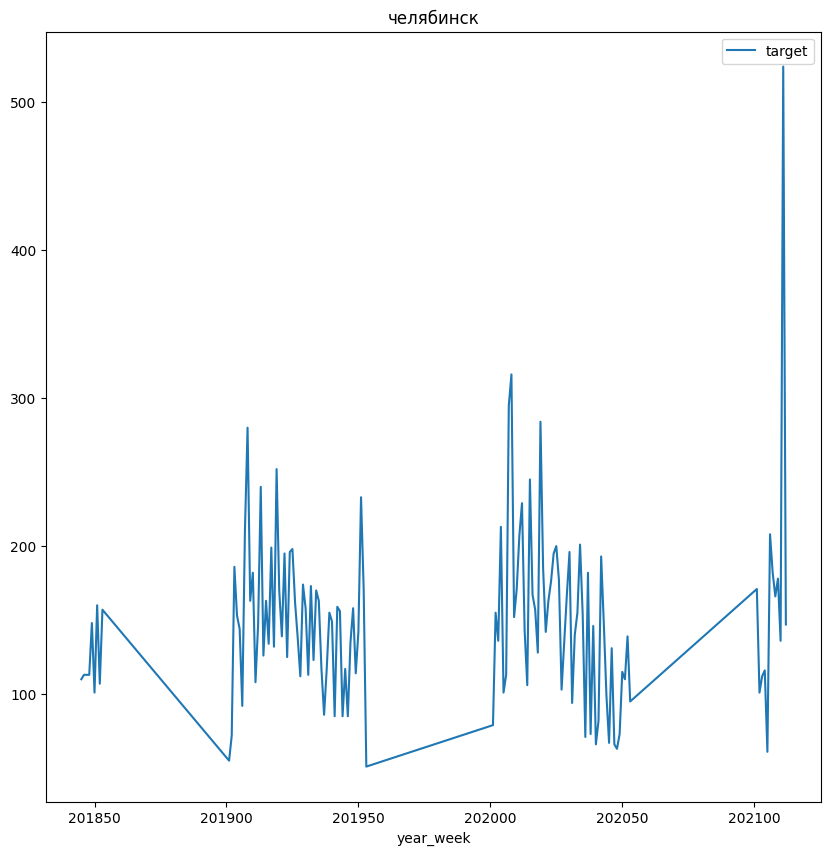

In [43]:
for city in sorted(top_cities):
    plt.figure()
    df[df['city']==city].groupby('year_week')['target'].sum().plot(figsize=(10, 10), legend=True, title=city)
    plt.show()

Продажи имеют годовую периодичность

<AxesSubplot: xlabel='year_week'>

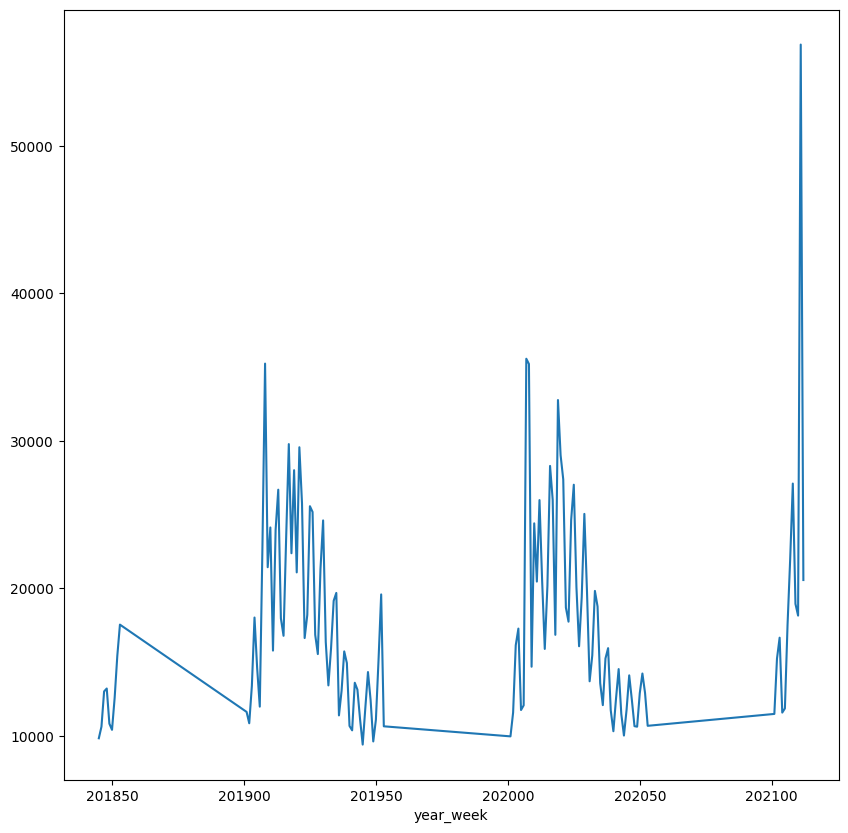

In [35]:
df.groupby('year_week')['target'].sum().plot(figsize=(10, 10))

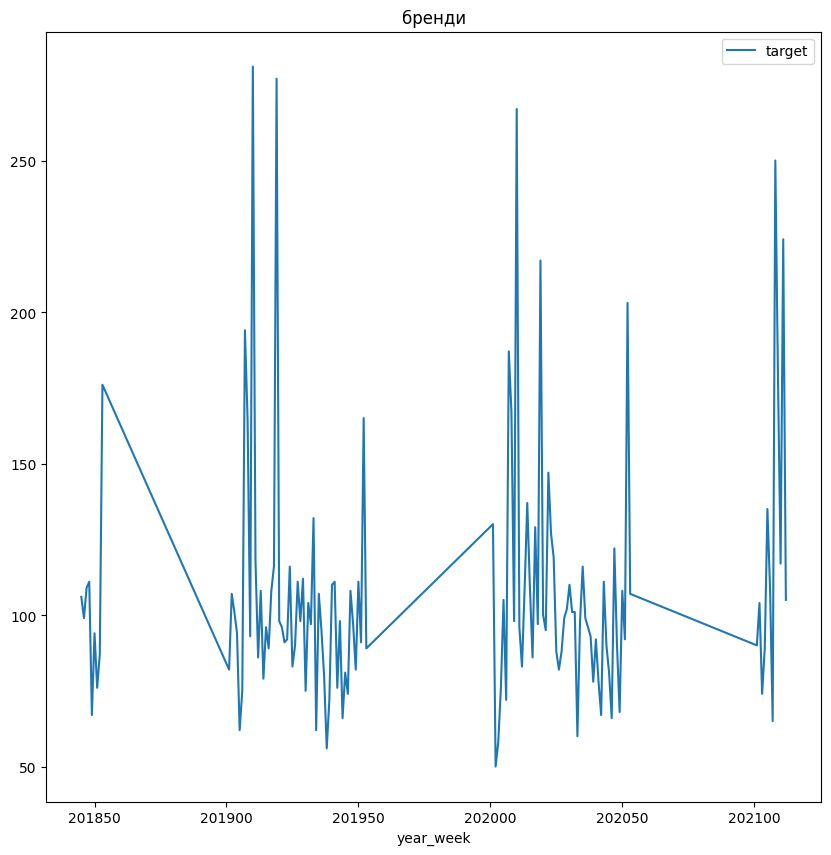

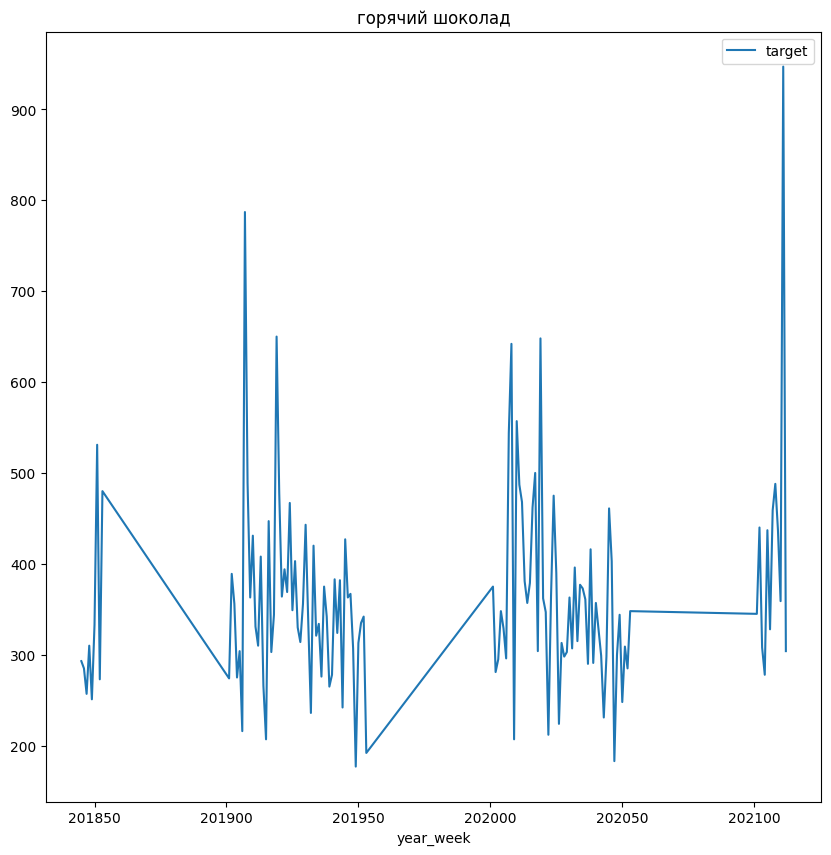

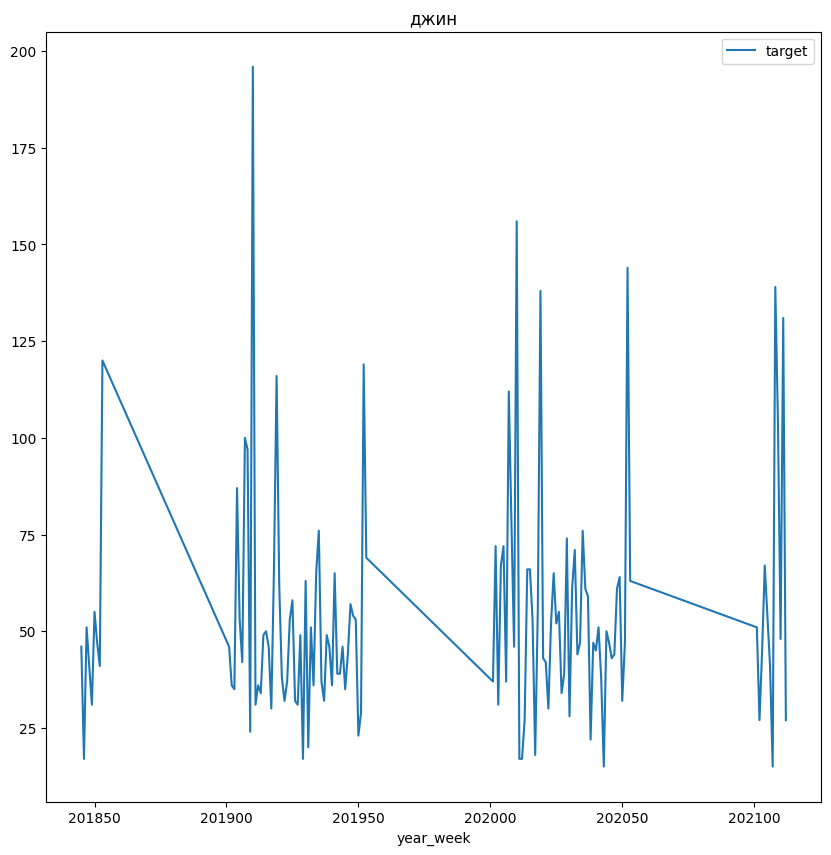

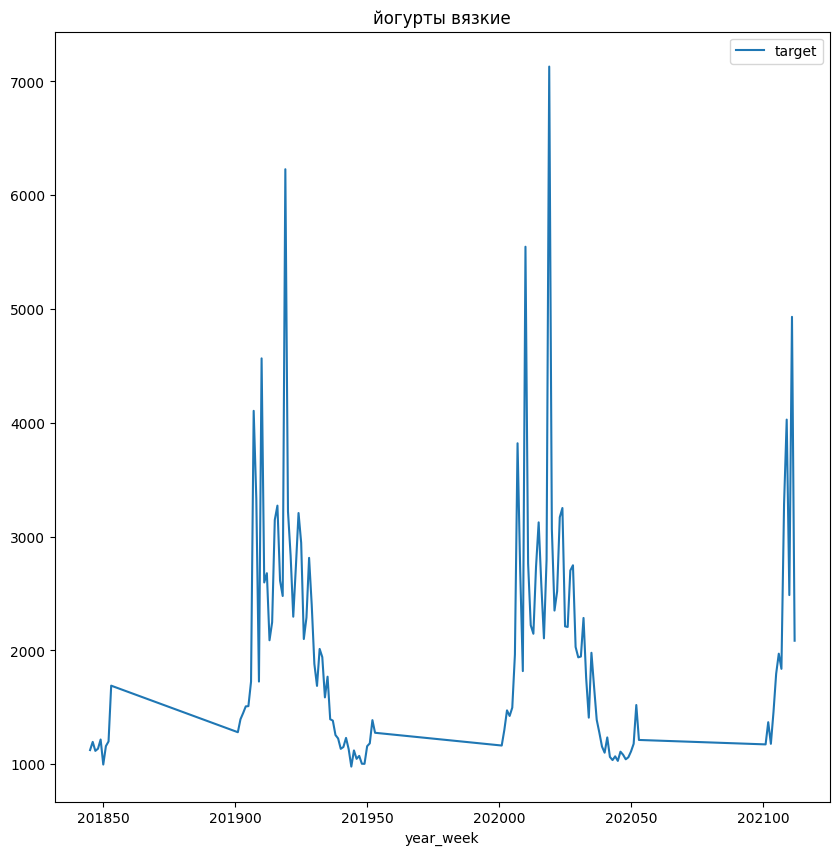

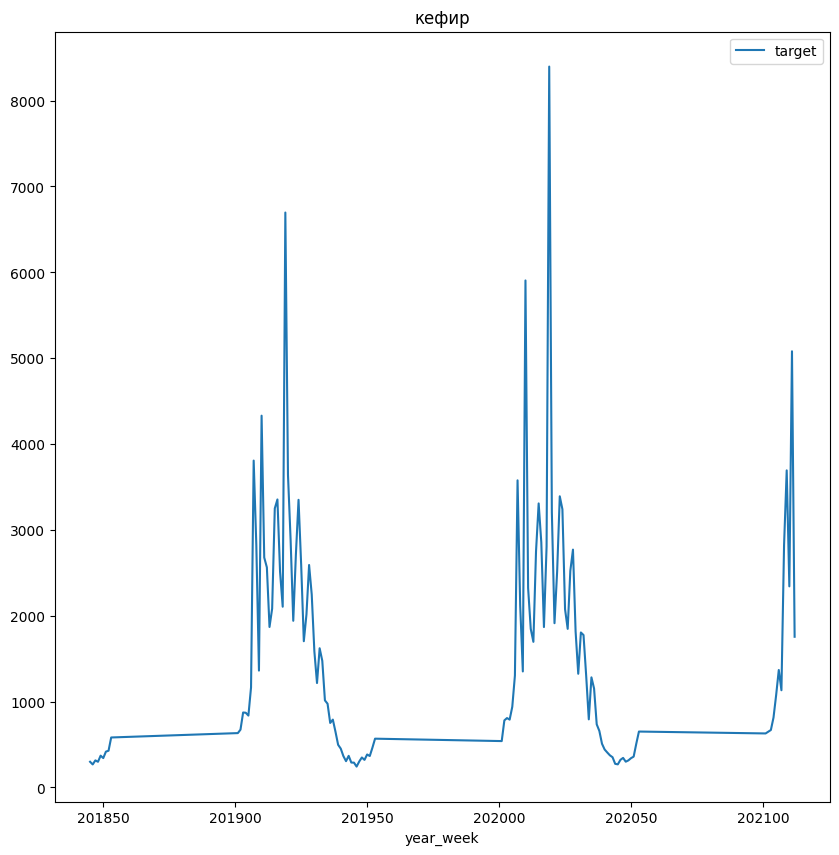

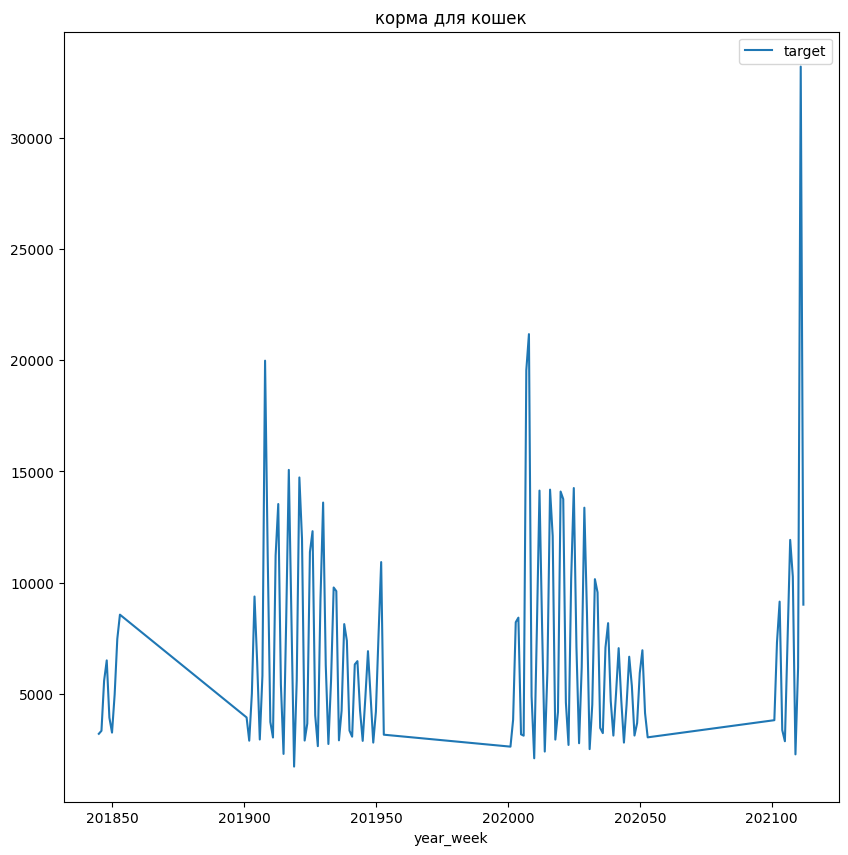

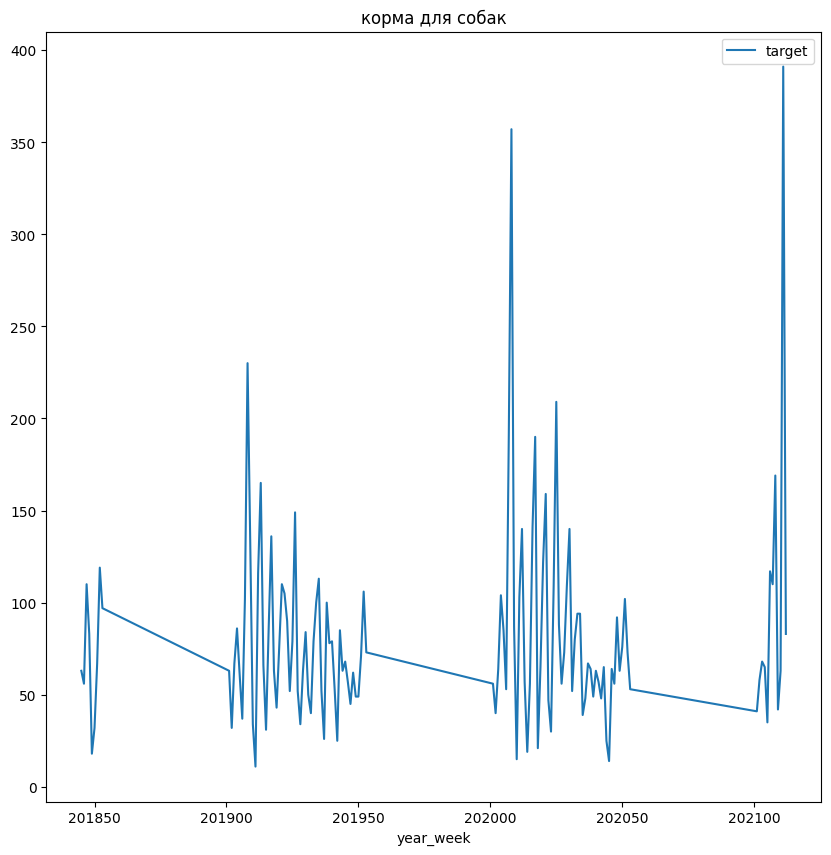

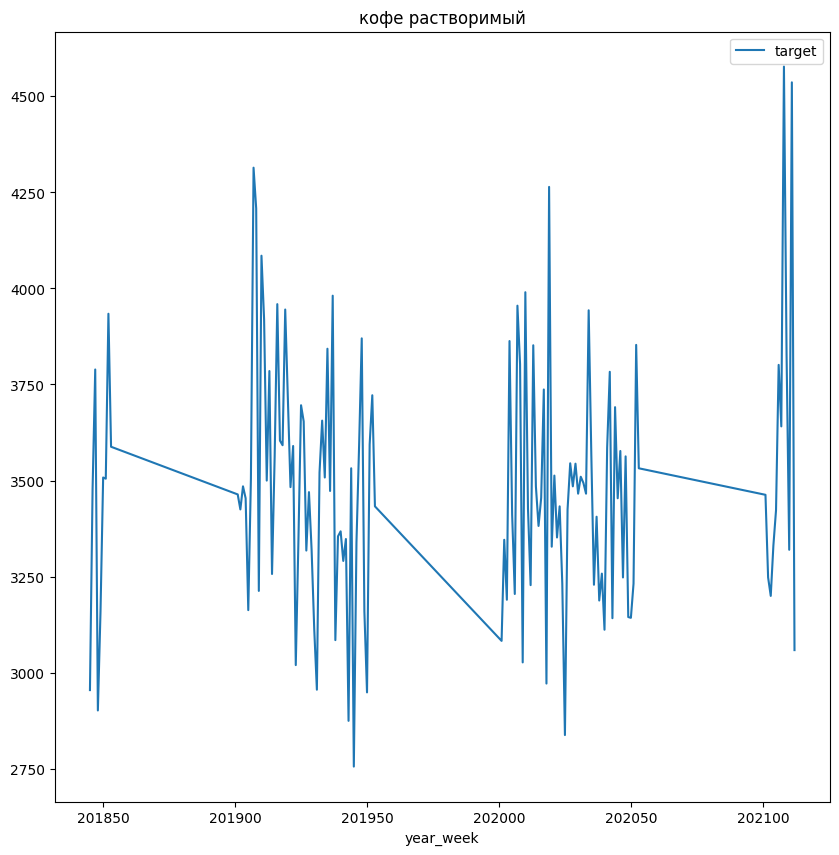

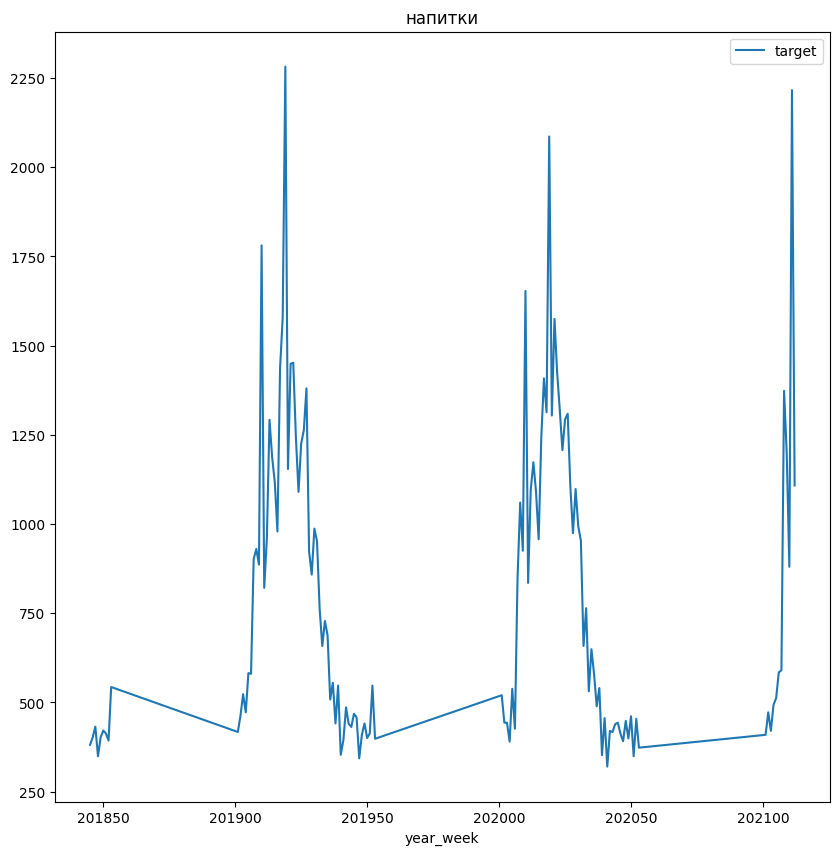

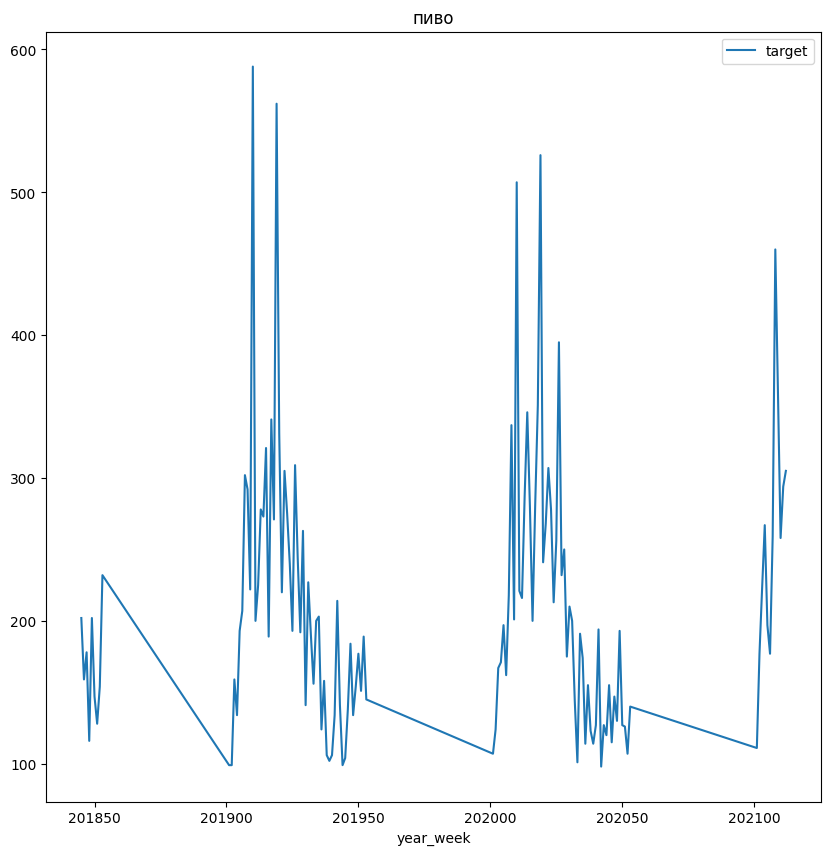

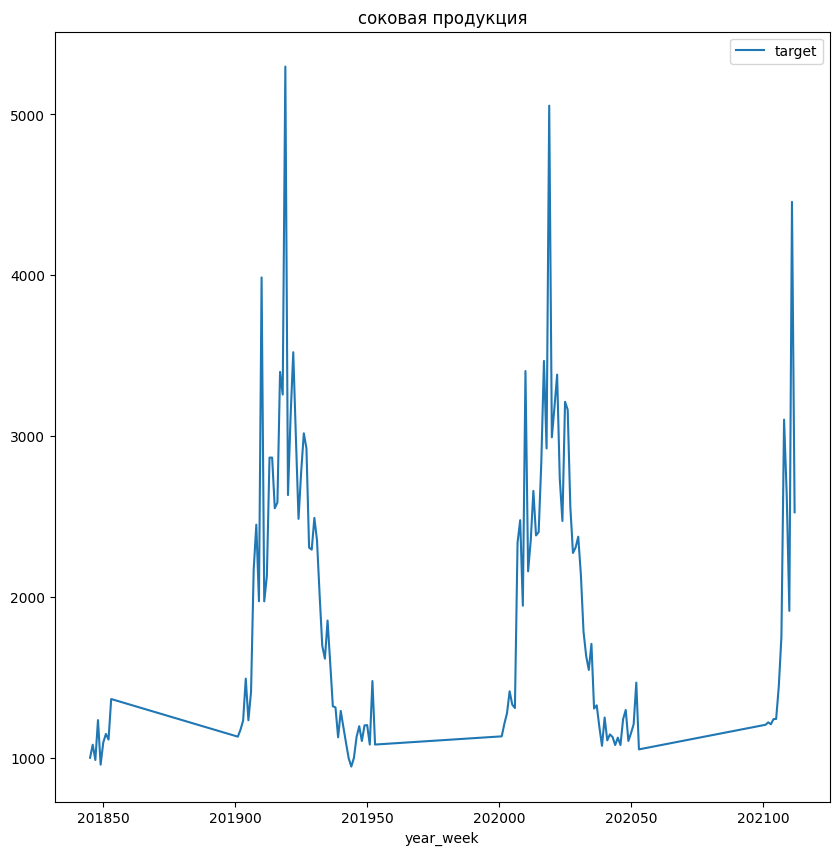

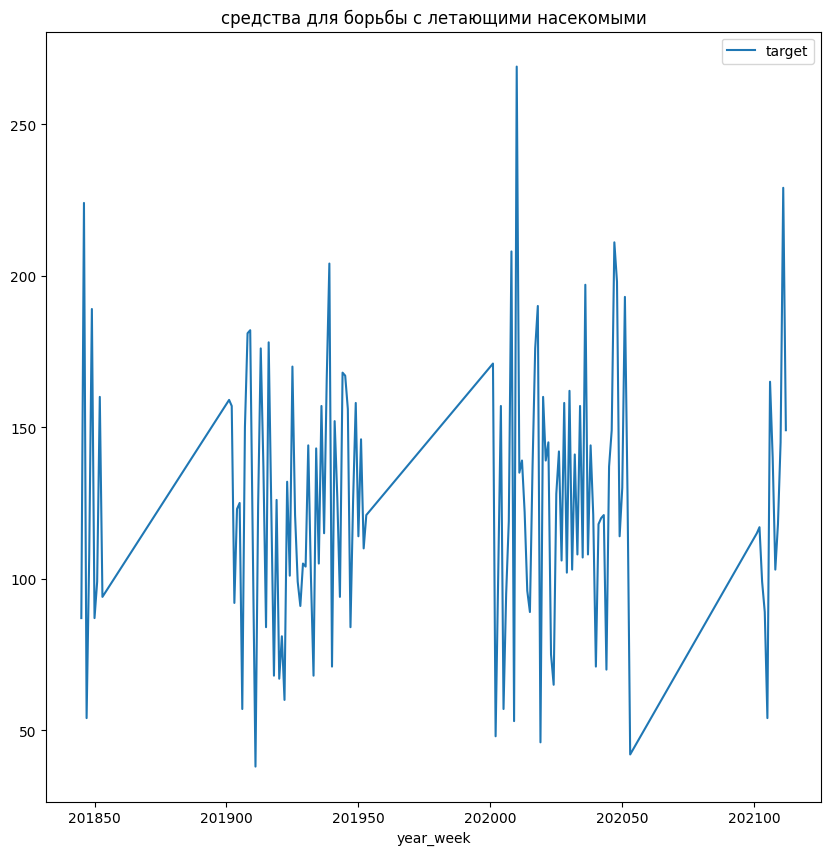

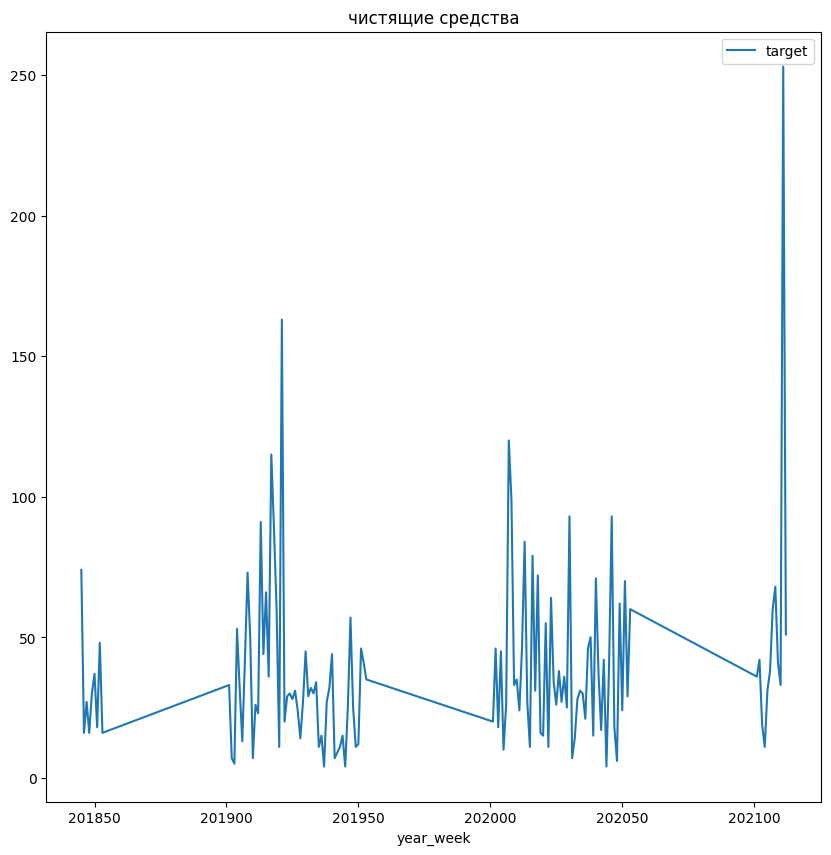

In [39]:
for category in sorted(list_categories):
    plt.figure()
    df[df['category']==category].groupby('year_week')['target'].sum().plot(figsize=(10, 10), legend=True, title=category)
    plt.show()